In [12]:
# step 1: import modules
import pybamm;from pybamm import constants,exp,tanh,sqrt;
import numpy as np
import matplotlib.pyplot as plt;import matplotlib as mpl;
import pandas as pd   ;import numpy as np;import os;import os;
from scipy.io import savemat,loadmat; 
import traceback;import imageio.v2 as imageio
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import (
    PlotDynamics,
    Plot_Loc_Var,
    Plot_Loc_Var_sol,
    Plot_Single_Static,
    may_cause_error,
)
fs=17; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [13]:
def electrolyte_conductivity_Nyman2008Exp_wEC(c_e,c_EC, T):
    x = c_EC / c_e
    coff = 1  
    ratio = ( coff/2 + coff/2 *  tanh((x-4.541*0.5)*1.5))
    sigma_e = (
        ratio * (
        0.1 * 0.06248 * (1+298.15-0.05559) * 
        (c_e/1e3) * (1 - 3.084 *sqrt(c_e/1e3) 
        + 1.33 *(1+ 0.03633 *(exp(1000/298.15))*c_e/1e3)   ) 
        / (1+(c_e/1e3)**4*( 0.00795 *exp(1000/298.15))) )
    )
    return sigma_e

In [14]:
# Step 2: model parameters
De = 3e-10;Dec = 5e-10; Dcross  = 3e-11; Xi=-1.4; t_0plus=0.28
D_ec_sei=5e-21; # 
model_0 = pybamm.lithium_ion.DFN(     
    options={
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",     
        "solvent diffusion": "EC wo refill"     } )
ChemistryChen=pybamm.parameter_sets.Chen2020 
ChemistryChen["electrolyte"] = "lipf6_Nyman2008Exp";
Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);
Para_0['EC transference number'] =    Xi
Para_0['Cation transference number'] =     t_0plus
Para_0['EC Lithium ion cross diffusivity [m2.s-1]'] = Dcross
Para_0['Typical EC Lithium ion cross diffusivity [m2.s-1]'] =  Dcross
Para_0['EC diffusivity in electrolyte [m2.s-1]'] =  Dec
Para_0['Ratio of lithium moles to SEI moles'] =  1
Para_0['EC diffusivity in SEI [m2.s-1]'] =  D_ec_sei
Para_0.update({
    'Electrolyte conductivity [S.m-1]':
    electrolyte_conductivity_Nyman2008Exp_wEC}, )
Para_0['Ratio of lithium moles to SEI moles'] =  1

c_e = model_0.variables["Electrolyte concentration [mol.m-3]"]
T = model_0.variables["Cell temperature [K]"]
c_EC = model_0.variables["EC concentration [mol.m-3]"]
model_0.variables["c(EC) over c(Li+)"] = c_EC / c_e
model_0.variables["Electrolyte conductivity [S.m-1]"] =(
    Para_0['Electrolyte conductivity [S.m-1]'](c_e,c_EC, T))
model_0.variables["Electrolyte diffusivity [m2.s-1]"] =(
    Para_0['Electrolyte diffusivity [m2.s-1]'](c_e,c_EC, T))

Confirm: using solvent-diffusion limited
using EC wo refill for Li+


In [15]:
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R7/'; 
Target  = 'a4_1_base_run_to_fail/'
if not os.path.exists(BasicPath + Target):
    os.mkdir(BasicPath + Target);

In [22]:
print(len(Sol_All))
print(Succ_Cyc)
print(Sol_All)

6
[100, 10, 10, 10, 10, 10]
[<pybamm.solvers.solution.Solution object at 0x0000025F0929E820>, <pybamm.solvers.solution.Solution object at 0x0000025F0B08F5B0>, <pybamm.solvers.solution.Solution object at 0x0000025F7F4AFFA0>, <pybamm.solvers.solution.Solution object at 0x0000025F0C215400>, <pybamm.solvers.solution.Solution object at 0x0000025F08EC20A0>, <pybamm.solvers.solution.Solution object at 0x0000025F14B50070>]


In [17]:
Sol_All[0].cycles[99].steps

In [24]:
step_switch = 3
expe_i    = pybamm.Experiment( 
        ExpList[step_switch] * 
        SaveAsList[step_switch]) 
model_new = model_old.set_initial_conditions_from(
    Sol_All[-1], inplace=False)
sim_new    = pybamm.Simulation(
    model_new,        experiment = expe_i,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),
    #var_pts=var_pts,
    #submesh_types=submesh_types
    ) #mode="safe"
sol_new    = sim_new.solve(
    calc_esoh=False,
    save_at_cycles = SaveAsList[step_switch])   

ModelError: initial condition is outside of variable bounds (0, inf) for variable 'Porosity times concentration(Negative electrode porosity times concentration, Separator porosity times concentration, Positive electrode porosity times concentration)'.

In [53]:
print(Sol_All[-1].cycles[-1].steps[-1]["Terminal voltage [V]"].entries)
# important notes: if we want to check wheter simulation fail, cannot do cycles[-1].steps[-1], 
# because it will just give the last one and may not have finish everything
print(Sol_All[-1].cycles[-1].steps[-1]["Current [A]"].entries)
#Sol_All[-1].cycles[-1].steps[-1]["Porosity times concentration"].entries
Sol_All[-1].cycles[-1].steps

[2.75455865 3.00387843 3.03751909 3.05140628 3.05856436 3.06403909
 3.07002109 3.08046433 3.20959937 3.90198729 4.06351299 4.22569232]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Report two bugs here (may be ): dynamic plot cannot sincerely refelct what is in the 

In [32]:
output_variables3 = [
    "Terminal voltage [V]",
    "Discharge capacity [A.h]",
    #"Negative electrode potential [V]",
    "Negative electrode porosity",
    "Porosity times concentration",
    "Electrolyte potential [V]",
    "Electrolyte current density [A.m-2]",
    'Electrolyte conductivity [S.m-1]',
    "Electrolyte concentration [mol.m-3]",
    #"Sum of positive electrode interfacial current densities",

    #"Li+ source term refill",
]
quick_plot = pybamm.QuickPlot(
    Sol_All[-1].cycles[-1], 
    output_variables3,
    variable_limits='tight',time_unit='hours',n_rows=2,
    figsize = (16,9)) #     spatial_unit='mm',
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=19.85577016023288, description='t', max=20.63757573051563, min=19.8557…

In [29]:
# Plot a pair of loc dependent varibles - within one step
def Plot_Loc_Var_sol( sol,x_loc_all, key_all, cycle, step,colormap  ): # for initial solution object
    Num_subplot = len(key_all); # must have 2+ keys
    fig, axs = plt.subplots(1,Num_subplot, figsize=(7*Num_subplot,5),tight_layout=True)
    for i in range(0,Num_subplot):
        x_loc=x_loc_all[i]; key=key_all[i];
        LinesNmum = len(sol.cycles[cycle].steps[step][key].entries[0,:] )
        cmap_i = mpl.cm.get_cmap(colormap, LinesNmum) 
        for j in range(0,LinesNmum):
            axs[i].plot(
                sol.cycles[cycle].steps[step][x_loc].entries[:,0], 
                sol.cycles[cycle].steps[step][key].entries[:,j], '-',
                color=cmap_i(j),)
            axs[i].set_title(key ,   fontdict={'family':'DejaVu Sans','size':fs-1})
            #axs[1].set_ylabel("Potential [V]",   fontdict={'family':'DejaVu Sans','size':fs})
            axs[i].set_xlabel(x_loc,   fontdict={'family':'DejaVu Sans','size':fs})
            
            labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
            
            axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
            axs[i].ticklabel_format( axis='x', style='sci',scilimits=[-0.01,0.01], useOffset=None, useLocale=None, useMathText=None)
            #axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)  
    return 

In [58]:
print(Sol_All[-1].cycles[-1].steps[1]["Electrolyte conductivity [S.m-1]"].entries[:,-1])

[6.78118503e-07            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan]


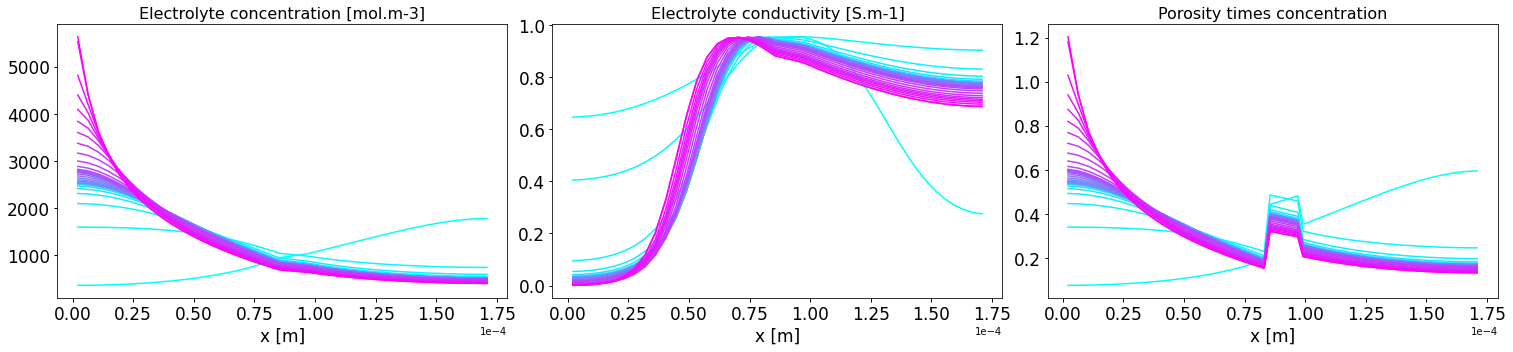

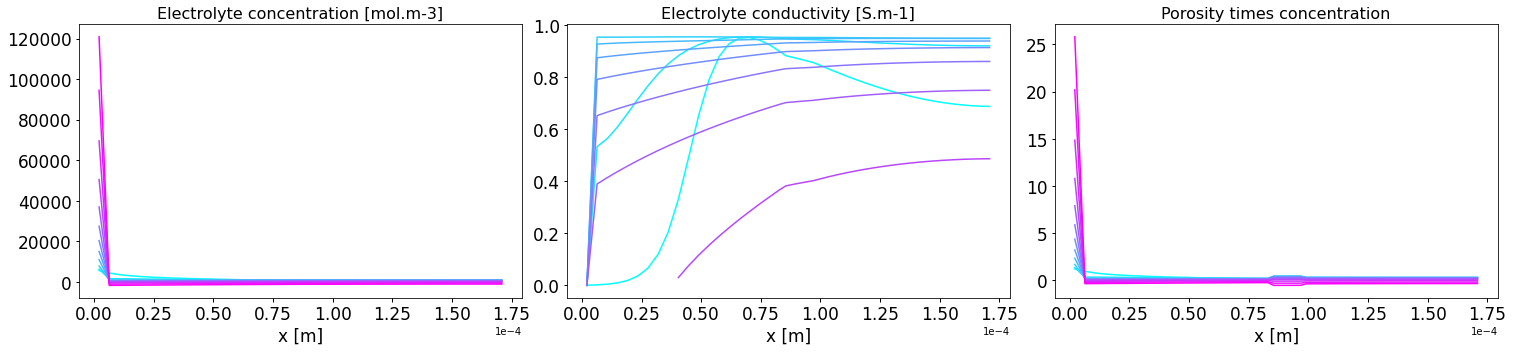

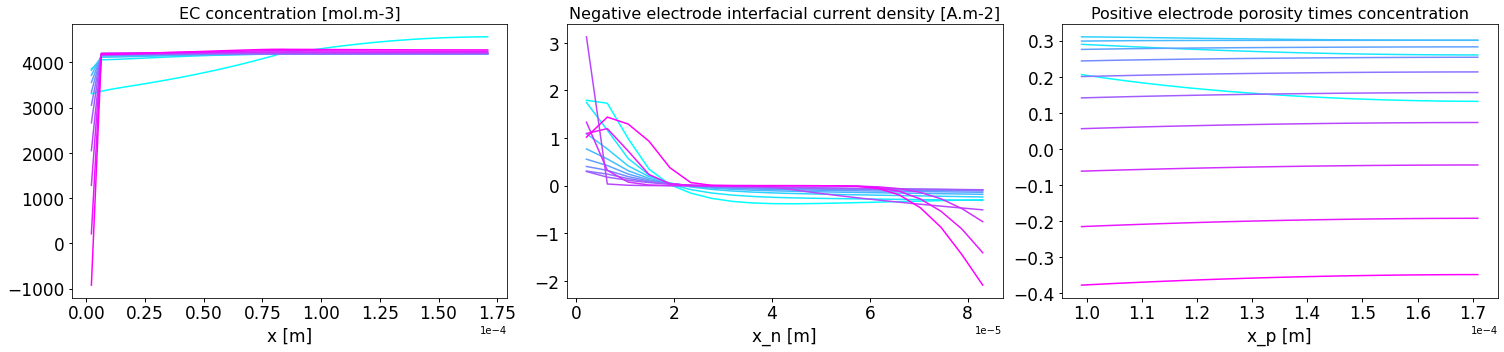

In [56]:
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x [m]","x [m]","x [m]","x [m]"], 
    [
        "Electrolyte concentration [mol.m-3]",
        "Electrolyte conductivity [S.m-1]",
        "Porosity times concentration",],
    -1,0,'cool')
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x [m]","x [m]","x [m]","x [m]"], 
    [
        "Electrolyte concentration [mol.m-3]",
        "Electrolyte conductivity [S.m-1]",
        "Porosity times concentration",],
    -1,1,'cool')
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x [m]","x_n [m]","x_p [m]"], 
    [
        "EC concentration [mol.m-3]",
        "Negative electrode interfacial current density [A.m-2]",
        "Positive electrode porosity times concentration",],
    -1,1,'cool')

In [18]:
# Step 3: run set up model_0 and parameters:
V_max = 4.2;        V_min = 2.5; 
exp_text_1 = [ (
    f"Discharge at 1C until {V_min} V",  
    "Rest for 1 hours",  
    f"Charge at 1C until {V_max} V" ) ]
exp_text_CD = [ (f"Discharge at 1C until {V_min} V",   ) ]
exp_text_RE = [ ("Rest for 1 hours", ) ]
exp_text_CC = [ (f"Charge at 1C until {V_max} V" ) ]
# further Steps if we can catch the seconds information:
ExpList     = [
    exp_text_1,exp_text_1,exp_text_1,
    exp_text_CD,exp_text_RE,exp_text_CC];
SaveAsList  = [
    100,       10,  1, 
    1, 1,1];
Succ_Cyc = []; Sol_All = [];    # contains all solutions and corresponding cycles
tot_target_cyc = 200
i = 0;step_switch = 0
while (i < tot_target_cyc):
    print('try to run %d cycles' % SaveAsList[step_switch])
    expe_i    = pybamm.Experiment( 
        ExpList[step_switch] * 
        SaveAsList[step_switch]) 
    # inherit previous resuls or run model from scratch
    try:   # run the model
        if i == 0: # first time or never succeed, run model from scratch:
            sim_0    = pybamm.Simulation(
                model_0,        experiment = expe_i,
                parameter_values = Para_0,
                solver = pybamm.CasadiSolver(),
                #var_pts=var_pts,
                #submesh_types=submesh_types
                ) #mode="safe"
            sol_0    = sim_0.solve(
                calc_esoh=False,
                save_at_cycles = SaveAsList[step_switch])
            print(sol_0.cycles[-1].steps[-1]["Terminal voltage [V]"].entries[-1])
        else: # succeeded before, 
            model_new = model_old.set_initial_conditions_from(
                sol_old, inplace=False)
            sim_new    = pybamm.Simulation(
                model_new,        experiment = expe_i,
                parameter_values = Para_0,
                solver = pybamm.CasadiSolver(),
                #var_pts=var_pts,
                #submesh_types=submesh_types
                ) #mode="safe"
            sol_new    = sim_new.solve(
                calc_esoh=False,
                save_at_cycles = SaveAsList[step_switch])   
            print(sol_new.cycles[SaveAsList[step_switch]-1].steps[-1]["Terminal voltage [V]"].entries[-1])  
    except:
        print('Failed and shorten cycles')
        step_switch += 1
        if (step_switch >= len(SaveAsList)):
            print('Exit as no options left')
            break
    else:        
        if i == 0: 
            model_old = model_0; sol_old = sol_0    
        else: 
            model_old = model_new; sol_old = sol_new
            del model_new,sol_new
        Sol_All.append(sol_old);
        Succ_Cyc.append(SaveAsList[step_switch])
        i += SaveAsList[step_switch]
        print('Succeed! Now it is the %dth cycles' % i)    



try to run 100 cycles
4.199989999999972
Succeed! Now it is the 100th cycles
try to run 100 cycles


2022-10-24 14:16:44.782 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Maximum voltage' was triggered during 'Rest for 1 hours'. The returned solution only contains up to step 2 of cycle 50. 


Failed and shorten cycles
try to run 10 cycles
4.199990000000001
Succeed! Now it is the 110th cycles
try to run 10 cycles
4.199990000000002
Succeed! Now it is the 120th cycles
try to run 10 cycles
4.199989999999999
Succeed! Now it is the 130th cycles
try to run 10 cycles
4.199990000000001
Succeed! Now it is the 140th cycles
try to run 10 cycles


2022-10-24 14:19:51.762 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Maximum voltage' was triggered during 'Rest for 1 hours'. The returned solution only contains up to step 2 of cycle 10. 


4.2256923221957114
Succeed! Now it is the 150th cycles
try to run 10 cycles
Failed and shorten cycles
try to run 1 cycles
Failed and shorten cycles
try to run 1 cycles
Failed and shorten cycles
try to run 1 cycles
Failed and shorten cycles
try to run 1 cycles
Failed and shorten cycles
Exit as no options left


In [19]:
# step 4: core: a big loop to run model_0 until it fail
# target: change steps; print out the limit;
# todo in the future: catch the wrong message time and use it to fast loction failure point
# sample information o catch: 
# Simulation error: Maximum number of decreased steps occurred at t=106279.54960562677.
#  D_ec_sei=1e-20; is a nice value to catch errors, can run about 30 1C cycles, 

In [20]:
# step 5: post-proessing: for only 1C discharge, print the last 1C dischagre capacity, 
# then critical variables as static lines or dynamic plots in the last cycle 
# for ageing with RPT, print the last RPT, then discharge capacity in every ageing cycle, 
# then for last cycle, critical variables
# critical variables should include: terminal voltage, electrolyte potential; porosity; 
# electrolyte diffusivity and conductivity; electrode soc,  